简易海龟策略

入场条件：当收盘价突破20日价格高点时，买入一单元股票；

加仓条件：当价格大于上一次买入价格的0.5个ATR（平均波幅），买入一单元股票，加仓次数不超过3次；

止损条件：当价格小于上一次买入价格的2个ATR时清仓；

离场条件：当价格跌破10日价格低点时清仓。

这里的20日价格高点和10日价格低点构成唐奇安通道，所以海龟交易法则也可以理解成通道突破的趋势跟踪

In [11]:
import backtesting as bt
import pandas as pd
import tushare as ts
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import mpl
import warnings
warnings.filterwarnings('ignore')

class TurtleStrategy(bt.Strategy):

#默认参数
    params = (('long_period',20),
              ('short_period',10),  
              ('printlog', False), )   

    def __init__(self):        
        self.order = None      
        self.buyprice = 0      
        self.buycomm = 0      
        self.buy_size = 0      
        self.buy_count = 0       
        # 海龟交易法则中的唐奇安通道和平均波幅ATR        
        self.H_line = bt.indicators.Highest(self.data.high(-1), period=self.p.long_period)        
        self.L_line = bt.indicators.Lowest(self.data.low(-1), period=self.p.short_period)       
        self.TR = bt.indicators.Max((self.data.high(0)- self.data.low(0)),\
                                    abs(self.data.close(-1)-self.data.high(0)), \
                                    abs(self.data.close(-1)  - self.data.low(0)))        
        self.ATR = bt.indicators.SimpleMovingAverage(self.TR, period=14)       
        # 价格与上下轨线的交叉      
        self.buy_signal = bt.ind.CrossOver(self.data.close(0), self.H_line)        
        self.sell_signal = bt.ind.CrossOver(self.data.close(0), self.L_line)    

    def next(self): 
        if self.order:
            return        
        #入场：价格突破上轨线且空仓时        
        if self.buy_signal > 0 and self.buy_count == 0:                                 
            self.buy_size = self.broker.getvalue() * 0.01 / self.ATR            
            self.buy_size  = int(self.buy_size  / 100) * 100                             
            self.sizer.p.stake = self.buy_size             
            self.buy_count = 1            
            self.order = self.buy()        
        #加仓：价格上涨了买入价的0.5的ATR且加仓次数少于3次（含）        
        elif self.data.close >self.buyprice+0.5*self.ATR[0] and self.buy_count > 0 and self.buy_count <=4:           
            self.buy_size  = self.broker.getvalue() * 0.01 / self.ATR            
            self.buy_size  = int(self.buy_size  / 100) * 100            
            self.sizer.p.stake = self.buy_size             
            self.order = self.buy()           
            self.buy_count += 1        
        #离场：价格跌破下轨线且持仓时        
        elif self.sell_signal < 0 and self.buy_count > 0:            
            self.order = self.sell()            
            self.buy_count = 0        
        #止损：价格跌破买入价的2个ATR且持仓时        
        elif self.data.close < (self.buyprice - 2*self.ATR[0]) and self.buy_count > 0:           
            self.order = self.sell()
            self.buy_count = 0   

    #交易记录日志（默认不打印结果）
    def log(self, txt, dt=None,doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print(f'{dt.isoformat()},{txt}')

    #记录交易执行情况（默认不输出结果）
    def notify_order(self, order):
        # 如果order为submitted/accepted,返回空
        if order.status in [order.Submitted, order.Accepted]:
            return
        # 如果order为buy/sell executed,报告价格结果
        if order.status in [order.Completed]: 
            if order.isbuy():
                self.log(f'买入:\n价格:{order.executed.price},\
                成本:{order.executed.value},\
                手续费:{order.executed.comm}')

                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            else:
                self.log(f'卖出:\n价格：{order.executed.price},\
                成本: {order.executed.value},\
                手续费{order.executed.comm}')

            self.bar_executed = len(self) 

        # 如果指令取消/交易失败, 报告结果
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('交易失败')
        self.order = None

    #记录交易收益情况（可省略，默认不输出结果）
    def notify_trade(self,trade):
        if not trade.isclosed:
            return
        self.log(f'策略收益：\n毛收益 {trade.pnl:.2f}, 净收益 {trade.pnlcomm:.2f}')

    def stop(self):
        self.log(f'(组合线：{self.p.long_period},{self.p.short_period})； \
        期末总资金: {self.broker.getvalue():.2f}', doprint=True)

In [12]:
class TradeSizer(bt.Sizer):
    params = (('stake', 1),)    
    def _getsizing(self, comminfo, cash, data, isbuy):        
        if isbuy:          
            return self.p.stake        
        position = self.broker.getposition(data)        
        if not position.size:            
            return 0        
        else:            
            return position.size        
        return self.p.stake

In [13]:
def plot_stock(code,title,start,end):
    dd=ts.get_k_data(code,autype='qfq',start=start,end=end)
    dd.index=pd.to_datetime(dd.date)
    dd.close.plot(figsize=(14,6),color='r')
    plt.title(title+'价格走势\n'+start+':'+end,size=15)
    plt.annotate(f'期间累计涨幅:{(dd.close[-1]/dd.close[0]-1)*100:.2f}%', xy=(dd.index[-150],dd.close.mean()), 
             xytext=(dd.index[-500],dd.close.min()), bbox = dict(boxstyle = 'round,pad=0.5',
            fc = 'yellow', alpha = 0.5),
             arrowprops=dict(facecolor='green', shrink=0.05),fontsize=12)
    plt.show()

In [14]:
def main(code,long_list,short_list,start,end='',startcash=1000000,com=0.001):
    #创建主控制器
    cerebro = bt.Cerebro()      
    #导入策略参数寻优
    cerebro.optstrategy(TurtleStrategy,long_period=long_list,short_period=short_list)  
    cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
    cerebro.addanalyzer(bt.analyzers.PyFolio)  
    #获取data_folder
    df=ts.get_k_data(code,autype='qfq',start=start,end=end)
    df.index=pd.to_datetime(df.date)
    df=df[['open','high','low','close','volume']]
    #将data_folder加载至回测系统
    data = bt.feeds.PandasData(dataname=df)    
    cerebro.adddata(data)
    #broker设置资金、手续费
    cerebro.broker.setcash(startcash)           
    cerebro.broker.setcommission(commission=com)    
    #设置买入设置，策略，数量
    cerebro.addsizer(TradeSizer)    
    print('期初总资金: %.2f' % cerebro.broker.getvalue())    
    cerebro.run(maxcpus=1)

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2


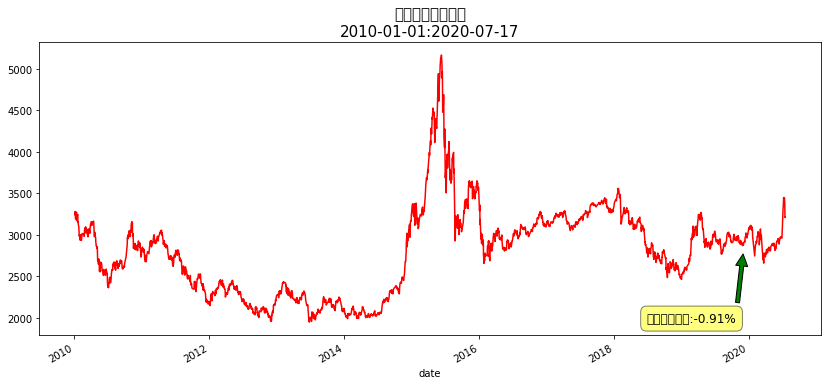

本接口即将停止更新，请尽快使用Pro版接口：https://tushare.pro/document/2
期初总资金: 1000000.00
2020-07-17,(组合线：20,5)；         期末总资金: 1390120.23
2020-07-17,(组合线：20,10)；         期末总资金: 1277599.38
2020-07-17,(组合线：20,15)；         期末总资金: 1364670.21
2020-07-17,(组合线：25,5)；         期末总资金: 1382881.56
2020-07-17,(组合线：25,10)；         期末总资金: 1243270.56
2020-07-17,(组合线：25,15)；         期末总资金: 1252566.38
2020-07-17,(组合线：30,5)；         期末总资金: 1320310.90
2020-07-17,(组合线：30,10)；         期末总资金: 1401899.81
2020-07-17,(组合线：30,15)；         期末总资金: 1356889.13
2020-07-17,(组合线：35,5)；         期末总资金: 1289133.30
2020-07-17,(组合线：35,10)；         期末总资金: 1257212.45
2020-07-17,(组合线：35,15)；         期末总资金: 1281212.74
2020-07-17,(组合线：40,5)；         期末总资金: 1309812.05
2020-07-17,(组合线：40,10)；         期末总资金: 1297384.29
2020-07-17,(组合线：40,15)；         期末总资金: 1384260.64
2020-07-17,(组合线：45,5)；         期末总资金: 1291239.64
2020-07-17,(组合线：45,10)；         期末总资金: 1283014.10
2020-07-17,(组合线：45,15)；         期末总资金: 1402853.31
2020-07-17,(组合线：50,5)；         期末总资

In [15]:
plot_stock('sh','上证综指','2010-01-01','2020-07-17')
long_list=range(20,70,5)
short_list=range(5,20,5)
main('sh',long_list,short_list,'2010-01-01','2020-07-17')

基于macd与ema的趋势跟踪策略

策略逻辑

做多：当macd在0轴的上方，10周期的ema上穿20周期的ema，做多；

平多: 价格跌破10周期的 ema，平多；

做空：当macd在0轴的下方，10周期的ema下穿20周期的ema，做空；

平空: 当价格在10周期的ema上方的时候，平空。

交易手数：每次交易1手。

初始资金： 5万元

交易费用： 万分之二。

运行周期： 30分钟

运行方式：运行在30分钟指数合约上，在这个30分钟指数合约上产生了信

2010-01-07T14:00:00,  SELL : data_name:RB99 price : 4454.324 , cost : 4454.324 , commission : 8.908648
2010-01-07T14:00:00, open symbol is : RB99 , price : 4454.324 
2010-01-11T09:30:00,  BUY : data_name:RB99 price : 4475.813 , cost : 4454.324 , commission : 8.951626000000001
2010-01-11T09:30:00, closed symbol is : RB99 , total_profit : -214.89000000000487 , net_profit : -232.75027400000488
2010-01-11T14:30:00,  BUY : data_name:RB99 price : 4502.828 , cost : 4502.828 , commission : 9.005656000000002
2010-01-11T14:30:00, open symbol is : RB99 , price : 4502.828 
2010-01-12T10:00:00,  SELL : data_name:RB99 price : 4483.236 , cost : 4502.828 , commission : 8.966472000000001
2010-01-12T10:00:00, closed symbol is : RB99 , total_profit : -195.92000000000553 , net_profit : -213.89212800000553
2010-01-13T10:00:00,  SELL : data_name:RB99 price : 4420.71 , cost : 4420.71 , commission : 8.84142
2010-01-13T10:00:00, open symbol is : RB99 , price : 4420.71 
2010-01-14T10:00:00,  BUY : data_name:RB9

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is depre

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:1147: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:1147: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:red'` for same effect.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:1546: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(turnover, ax=ax, **kwargs)


OverflowError: cannot convert float infinity to integer

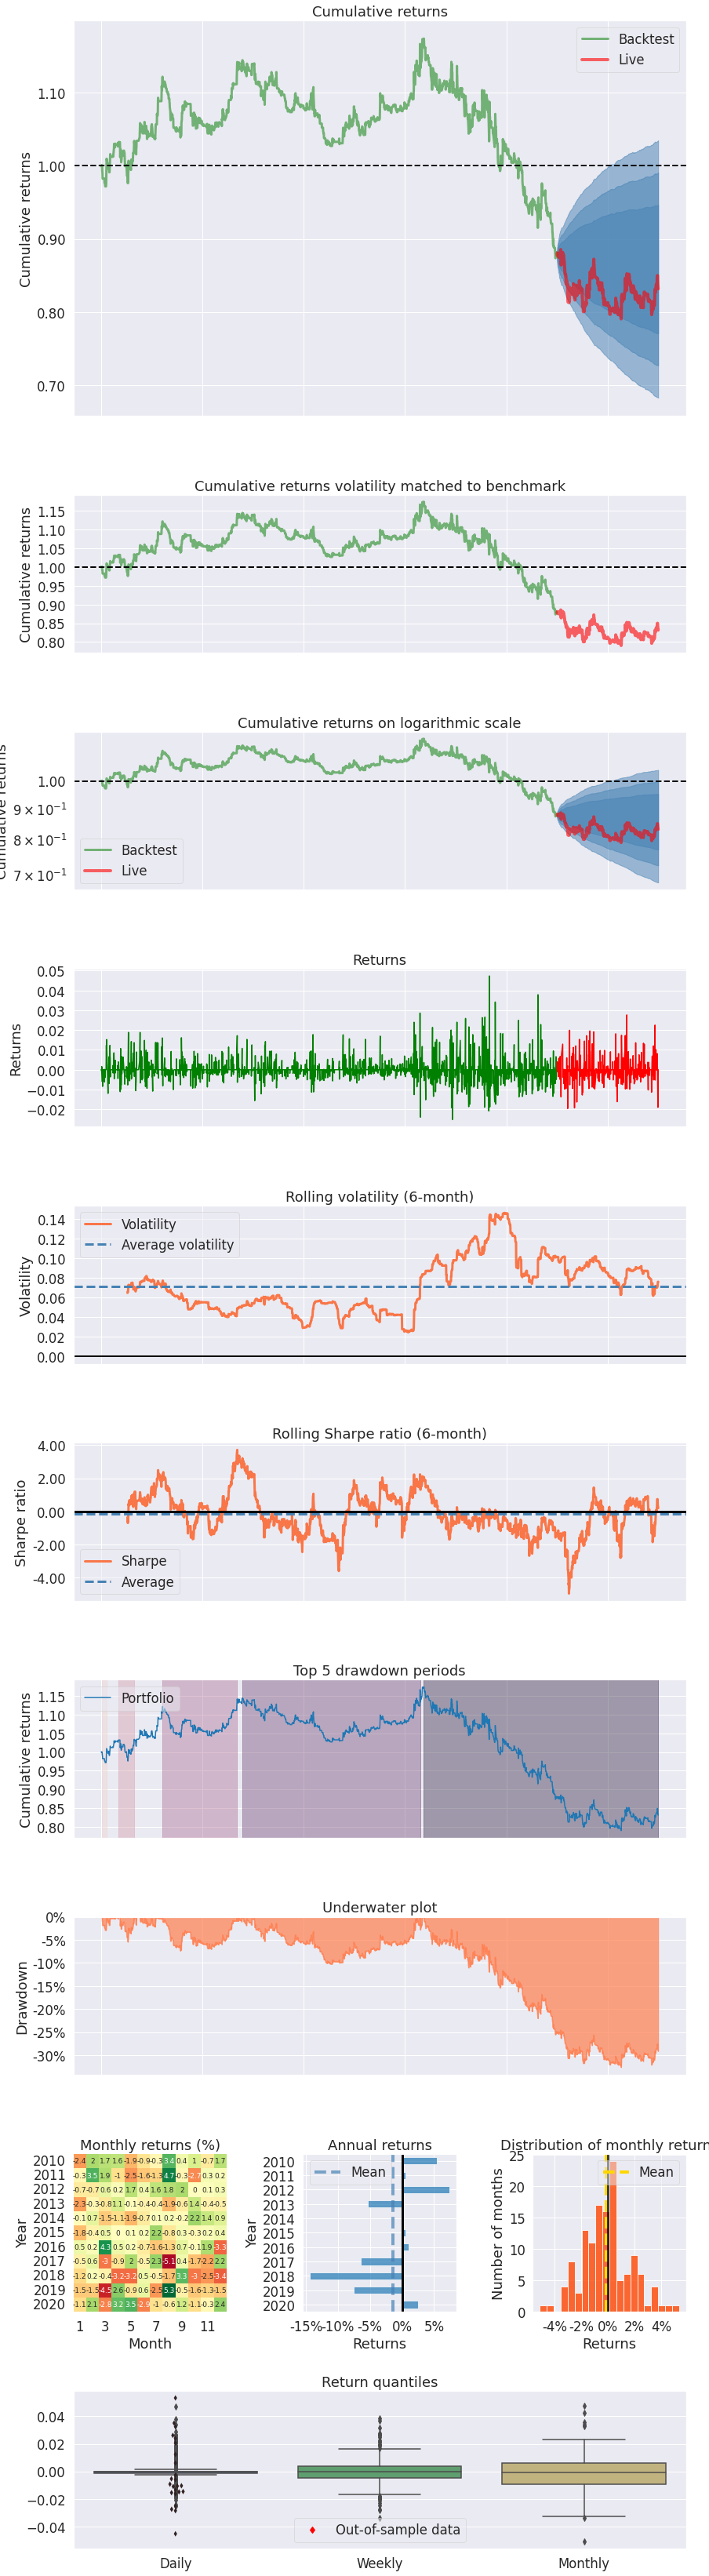

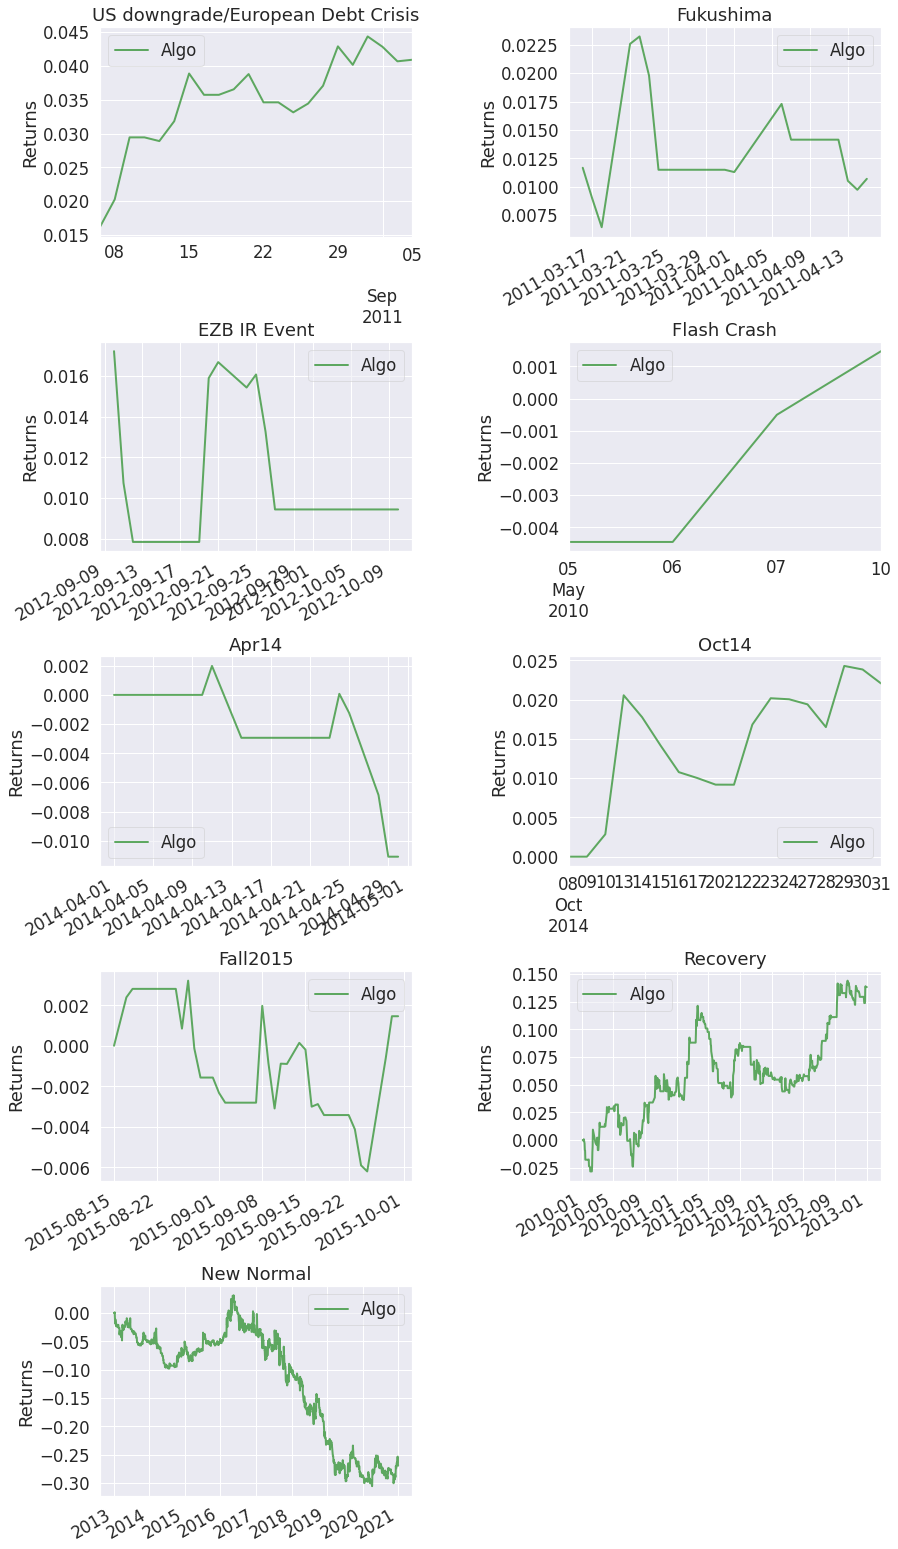

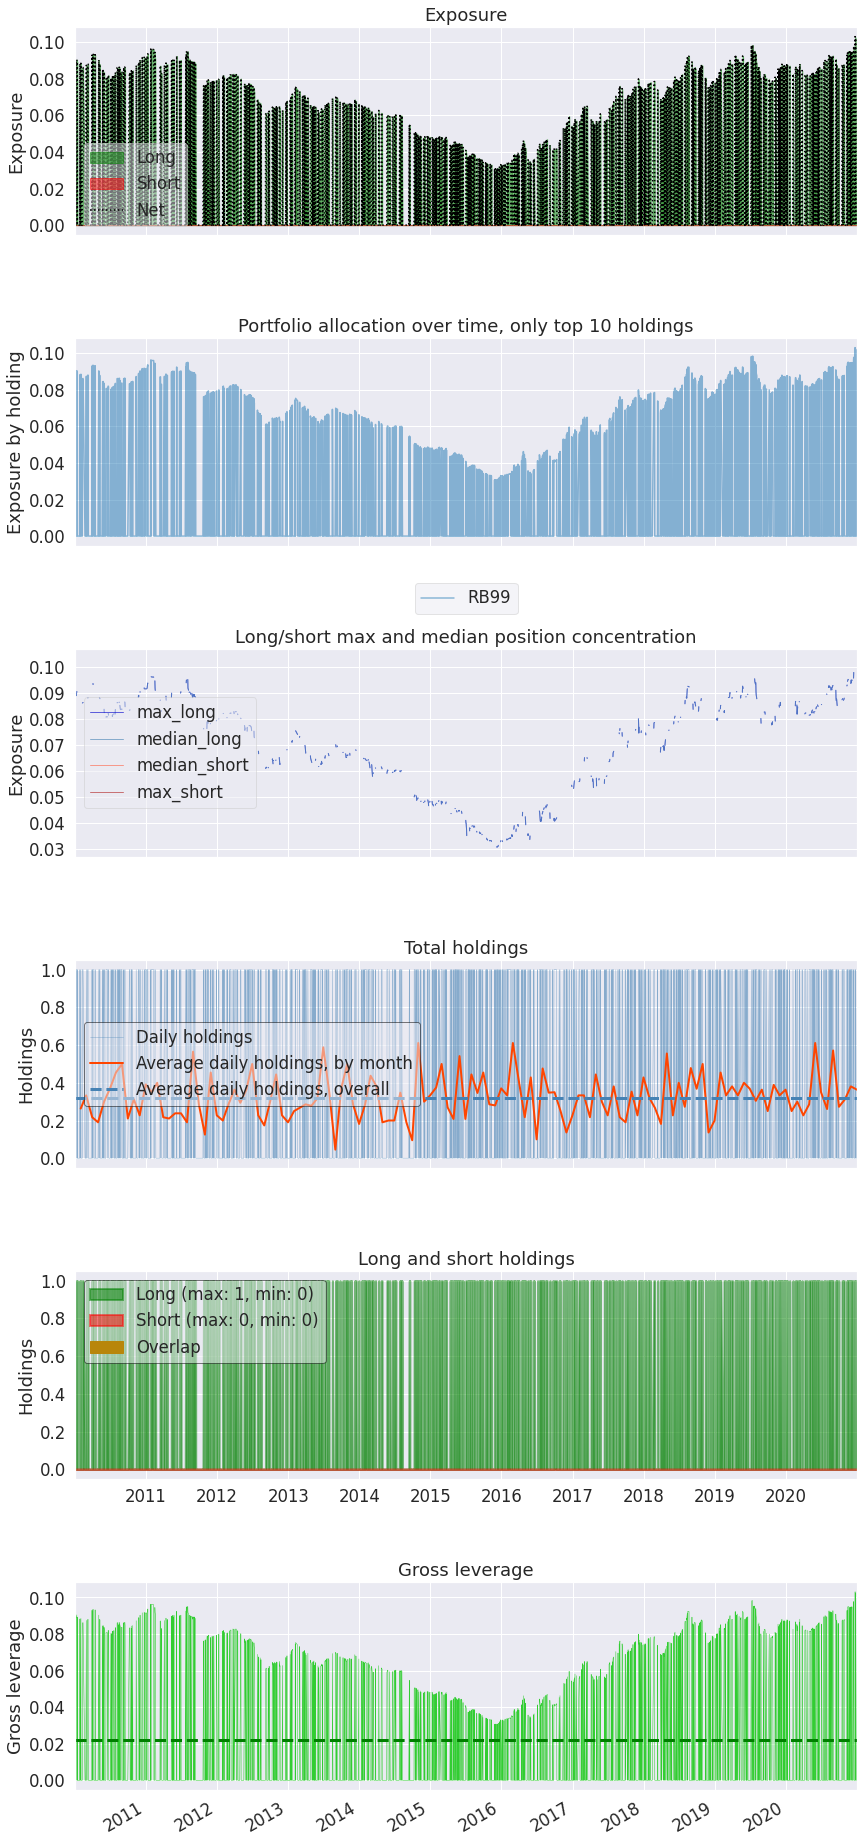

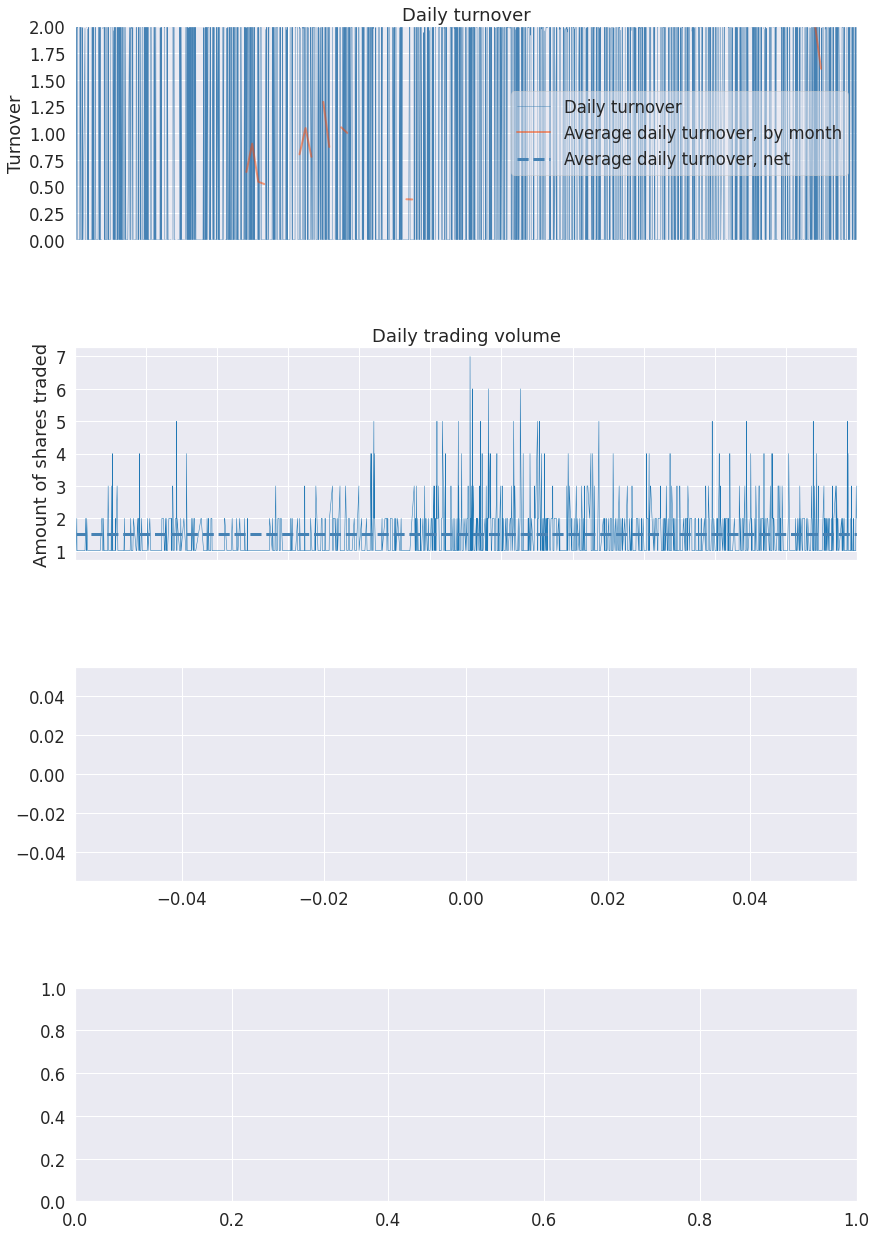

In [3]:
import time,datetime
import os,sys
import pickle 
# import talib
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
from sklearn import linear_model

import backtesting as bt 
from backtesting.comminfo import ComminfoFuturesPercent,ComminfoFuturesFixed # 期货交易的手续费用，按照比例或者按照金额
import pyfolio as pf
### 编写相应的策略,每个策略逻辑需要单独编写，回测和实盘直接运行策略类就行

class MACDStrategy(bt.Strategy):
    # 策略的参数
    params = (  ("period_me1",10),                  
                ("period_me2",20),                      
                ("period_signal",9),             
                
            )
    # log相应的信息
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or bt.num2date(self.datas[0].datetime[0])
        print('{}, {}'.format(dt.isoformat(), txt))

    # 初始化策略的data_folder
    def __init__(self):
        # 基本上常用的部分属性变量
        self.bar_num = 0                 # next运行了多少个bar
        self.current_date = None        # 当前交易日
        # 保存macd指标
        self.bt_macd_indicator = bt.indicators.MACD(self.datas[0],period_me1=self.p.period_me1,period_me2=self.p.period_me2,period_signal=self.p.period_signal)
        # 保存ema指标
        self.ema = bt.indicators.ExponentialMovingAverage(self.datas[0],period = self.p.period_me1 )
 

    def prenext(self):
        # 由于期货data_folder有几千个，每个期货交易日期不同，并不会自然进入next
        # 需要在每个prenext中调用next函数进行运行
        # self.next() 
        pass 
        
    # 在next中添加相应的策略逻辑
    def next(self):
        # 每次运行一次，bar_num自然加1,并更新交易日
        self.bar_num+=1

        # 计算相应的指标
        dif = self.bt_macd_indicator.macd
        dea = self.bt_macd_indicator.signal
        macd = 2*(dif - dea)
        # 当前状态
        data = self.datas[0]
        size = self.getposition(self.datas[0]).size # 持仓大小
        # 开仓，先平后开
        # 平多
        if size>0 and data.close[0]<self.ema[0]:
            self.close(data)
            size = 0
        # 平空
        if size<0 and data.close[0]>self.ema[0]:
            self.close(data)
            size = 0
            
        # 开多
        if size==0 and dif[-1]<0 and dif[0]>0 and macd>0:
            self.buy(data,size=1)
        
        # 开空
        if size==0 and dif[-1]>0 and dif[0]<0 and macd<0:
            self.sell(data,size=1)                        
                
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status == order.Rejected:
            self.log(f"Rejected : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Margin:
            self.log(f"Margin : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Cancelled:
            self.log(f"Concelled : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Partial:
            self.log(f"Partial : order_ref:{order.ref}  data_name:{order.p.data._name}")
         
        if order.status == order.Completed:
            if order.isbuy():
                self.log(f" BUY : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")

            else:  # Sell
                self.log(f" SELL : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")
    
    def notify_trade(self, trade):
        # 一个trade结束的时候输出信息
        if trade.isclosed:
            self.log('closed symbol is : {} , total_profit : {} , net_profit : {}' .format(
                            trade.getdataname(),trade.pnl, trade.pnlcomm))
            # self.trade_list.append([self.datas[0].datetime.date(0),trade.getdataname(),trade.pnl,trade.pnlcomm])
            
        if trade.isopen:
            self.log('open symbol is : {} , price : {} ' .format(
                            trade.getdataname(),trade.price))

            
    def stop(self):
        pass 
    
    
# 准备配置策略
cerebro = bt.Cerebro()
# 参数设置
data_kwargs = dict(
            fromdate = datetime.datetime(2010,1, 1),
            todate = datetime.datetime(2020,12,31),
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
            tmformat=('%H:%M:%S'), # 时间格式
            datetime=0,
            high=3,
            low=4,
            open=1,
            close=2,
            volume=5,
            openinterest=7)
    
# 加载螺纹钢指数data_folder
name = "RB99"
df = pd.read_csv("./future/15m/RB99.csv")
# 只要data_folder里面的这几列
df = df[['datetime','open','high','low','close','volume','open_interest']]
# 修改列的名字
df.index = pd.to_datetime(df['datetime'])
df = df[['open','high','low','close','volume','open_interest']]
df = df[(df.index<=data_kwargs['todate'])&(df.index>=data_kwargs['fromdate'])]
feed = bt.feeds.PandasDirectData(dataname = df)
cerebro.adddata(feed, name = name)
# 设置合约的交易信息，佣金设置为2%%，保证金率为10%，杠杆按照真实的杠杆来
comm=ComminfoFuturesPercent(commission=0.0002,margin=0.1, mult=10)
cerebro.broker.addcommissioninfo(comm, name= name)
cerebro.broker.setcash(50000.0)
# 添加策略
cerebro.addstrategy(MACDStrategy)
cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
cerebro.addanalyzer(bt.analyzers.PyFolio)
# 运行回测
results = cerebro.run()

pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2019-01-01',
    )

使用指数合约作为交易的合约

回测的一个核心原则就是要尽可能接近过去的实际情况，并且能够让这个策略逻辑能够应用到未来的交易中。

我们上个策略回测的时候，是直接在期货的指数合约上产生交易信号，然后在指数合约上产生交易，这样的回测很可能不准的，毕竟，在实际的交易中，很少有人能够复制期货指数去交易。大多都是交易流动量比较充足的合约，比如主力合约与次主力合约。

所以，用不可能复制的data_folder产生交易，是一种不合理的回测方式。

使用前复权、后复权、不复权的期货主力连续合约作为交易的合约

这种方式比较适合日内交易等交易频率比较高的策略，不持仓过夜，或者策略不会经历移仓换月。对于中长周期的策略，如果移仓换月，就必然导致回测结果出现问题。

总结

一般而言，中长期的趋势策略，一般要在真实的合约上产生交易信号；日内等不经历移仓换月的，使用主力连续合约也可以，这样回测可以减少加载的合约数量，使得回测速度快一些；套利类的策略，一般是需要使用真实的合约。

关于移仓换月

期货中由于合约的有效期都比较短，市场参与者需要不断转换交易的合约，比如在2021年年初可能需要交易RB2105,到2021年4月份，可能就是需要交易RB2109,因为合约的流动性比较好，有些特殊的交易者也有可能交易其他的合约。不同类型的交易者可能采用不同的移仓换月方法，但是不论采用哪种方式，大体上都是需要的。一些商业的行情软件，在形成主力连续合约的时候，会使用特定的标准，这些标准逐渐被大家接受，使用范围比较广。

1. 以持仓量确定主力合约


比如那个合约的持仓量比较大，那个就是主力合约。本文采用的主力合约的确认方式就是按照这种方式。

再比如，当下个合约的持仓量超过了当前主力合约的持仓量的1.2倍，就确定下个合约是主力合约，并且还可以制定规则是否允许主力合约往后退，比如现在主力合约的持仓量RB2105小于了RB2019，那么主力合约在下个交易日就会变成RB2109,如果允许主力合约往后退，近期的合约RB2105或者RB2107的持仓量超过了RB2109，就确认RB2105或者rb2107作为主力合约。

2.以交易量确定主力合约

同持仓量的确认方法一样，不过相对于持仓量，合约的交易量或者交易额，变动相对比较快一些。与以持仓量确认的主力合约的方式相比，两者移仓换月的交易日可能不一样。

1. 以持仓量与交易量的一定比例确定主力合约


一般情况下，比较活跃的期货，持仓量一般小于当日的成交量。比如，按照持仓量的80%与成交量的20%来确定哪个合约是主力合约，这也是一种方法。

总结

其实还有一些其他的确认那个合约是主力合约的方法。选择哪种方法，最主要的关键是要考虑使用的交易策略，最好的换月方法是能够和使用的交易策略相匹配的。



策略逻辑：

做多：当macd在0轴的上方，10周期的ema上穿20周期的ema，做多；

平多: 价格跌破10周期的 ema，平多；

做空：当macd在0轴的下方，10周期的ema下穿20周期的ema，做空；

平空: 当价格在10周期的ema上方的时候，平空。

交易手数：每次交易1手。

初始资金： 5万元

交易费用： 万分之二。

运行周期： 30分钟

运行方式：运行在30分钟指数合约上，在这个30分钟主力合约上产生了信号

2010-01-07T14:00:00,  SELL : data_name:RB1005 price : 4489.0 , cost : 4489.0 , commission : 8.978
2010-01-07T14:00:00, open symbol is : RB1005 , price : 4489.0 
2010-01-11T09:30:00,  BUY : data_name:RB1005 price : 4495.0 , cost : 4489.0 , commission : 8.99
2010-01-11T09:30:00, closed symbol is : RB1005 , total_profit : -60.0 , net_profit : -77.968
2010-01-11T14:30:00,  BUY : data_name:RB1005 price : 4508.0 , cost : 4508.0 , commission : 9.016
2010-01-11T14:30:00, open symbol is : RB1005 , price : 4508.0 
2010-01-12T10:00:00,  SELL : data_name:RB1005 price : 4487.0 , cost : 4508.0 , commission : 8.974
2010-01-12T10:00:00, closed symbol is : RB1005 , total_profit : -210.0 , net_profit : -227.99
2010-01-13T10:00:00,  SELL : data_name:RB1005 price : 4418.0 , cost : 4418.0 , commission : 8.836
2010-01-13T10:00:00, open symbol is : RB1005 , price : 4418.0 
2010-01-14T10:00:00,  BUY : data_name:RB1005 price : 4459.0 , cost : 4418.0 , commission : 8.918000000000001
2010-01-14T10:00:00, closed 

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is depre

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:1147: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:1147: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:red'` for same effect.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:1546: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(turnover, ax=ax, **kwargs)


OverflowError: cannot convert float infinity to integer

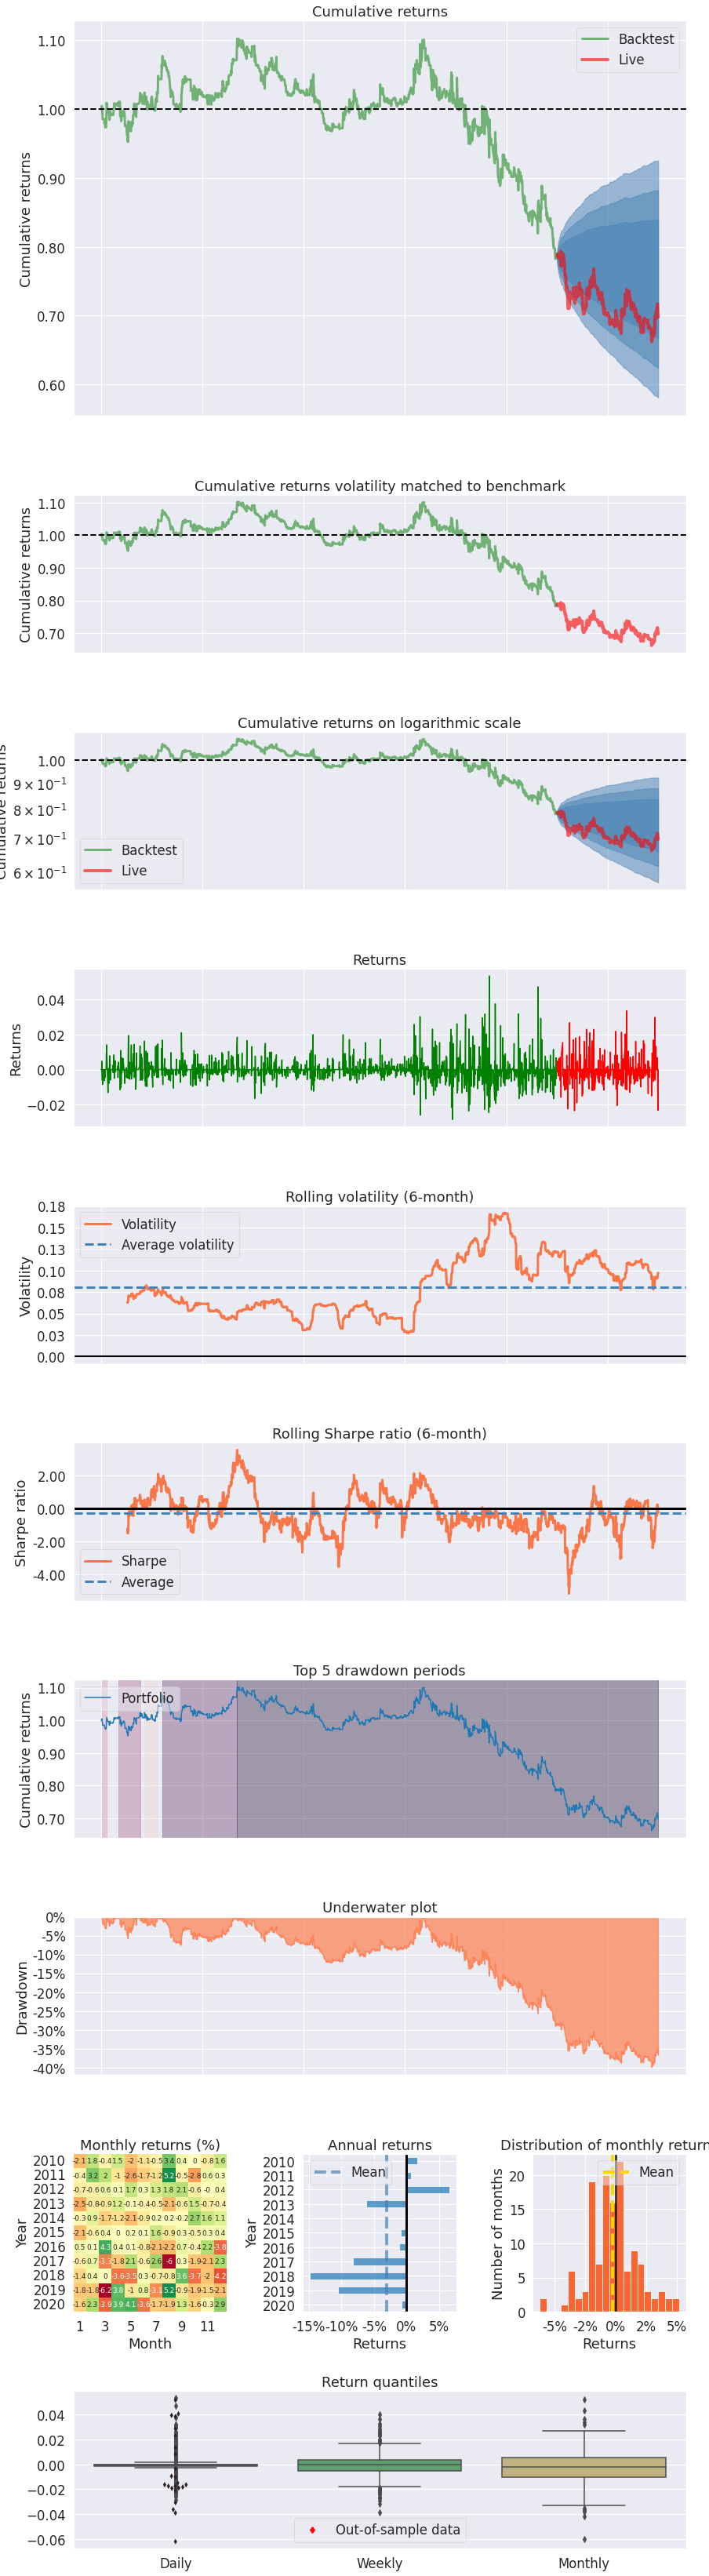

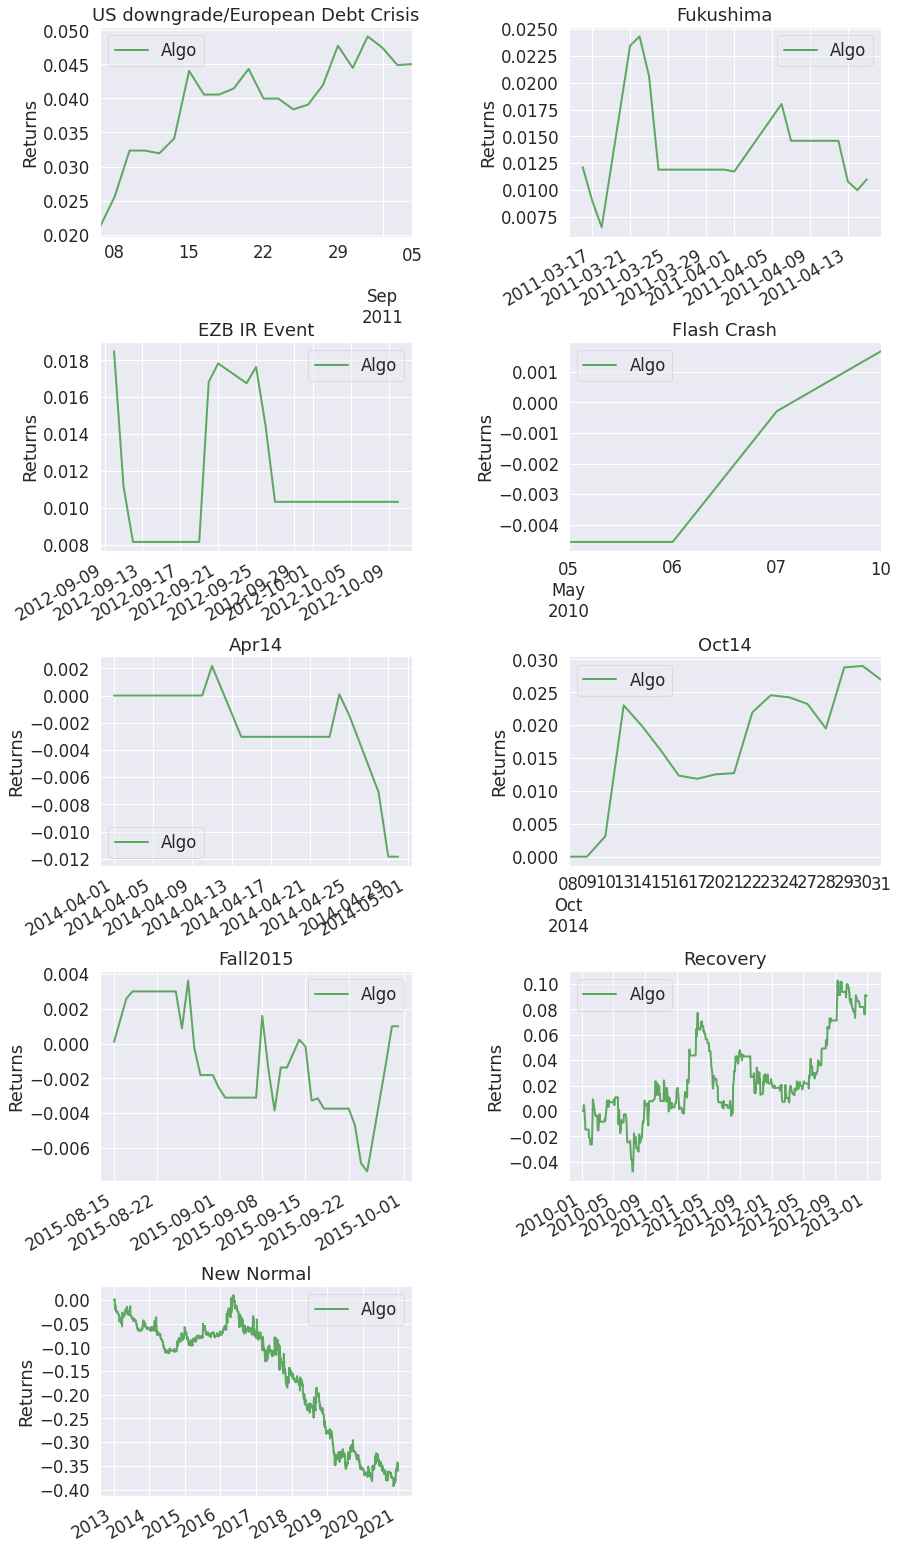

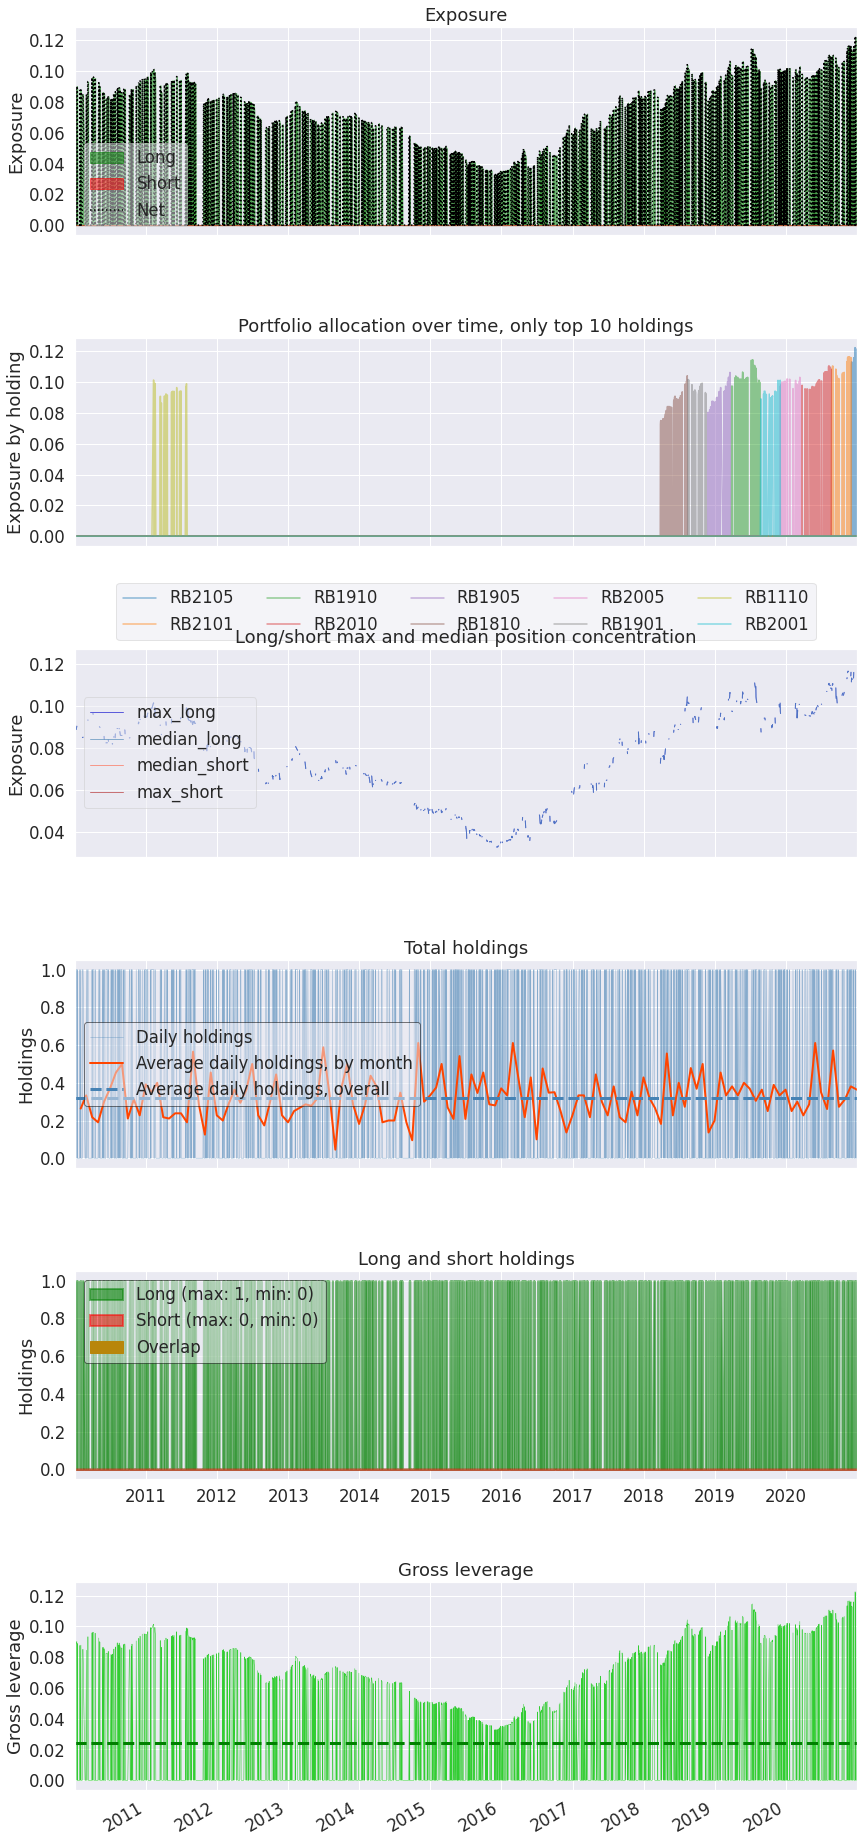

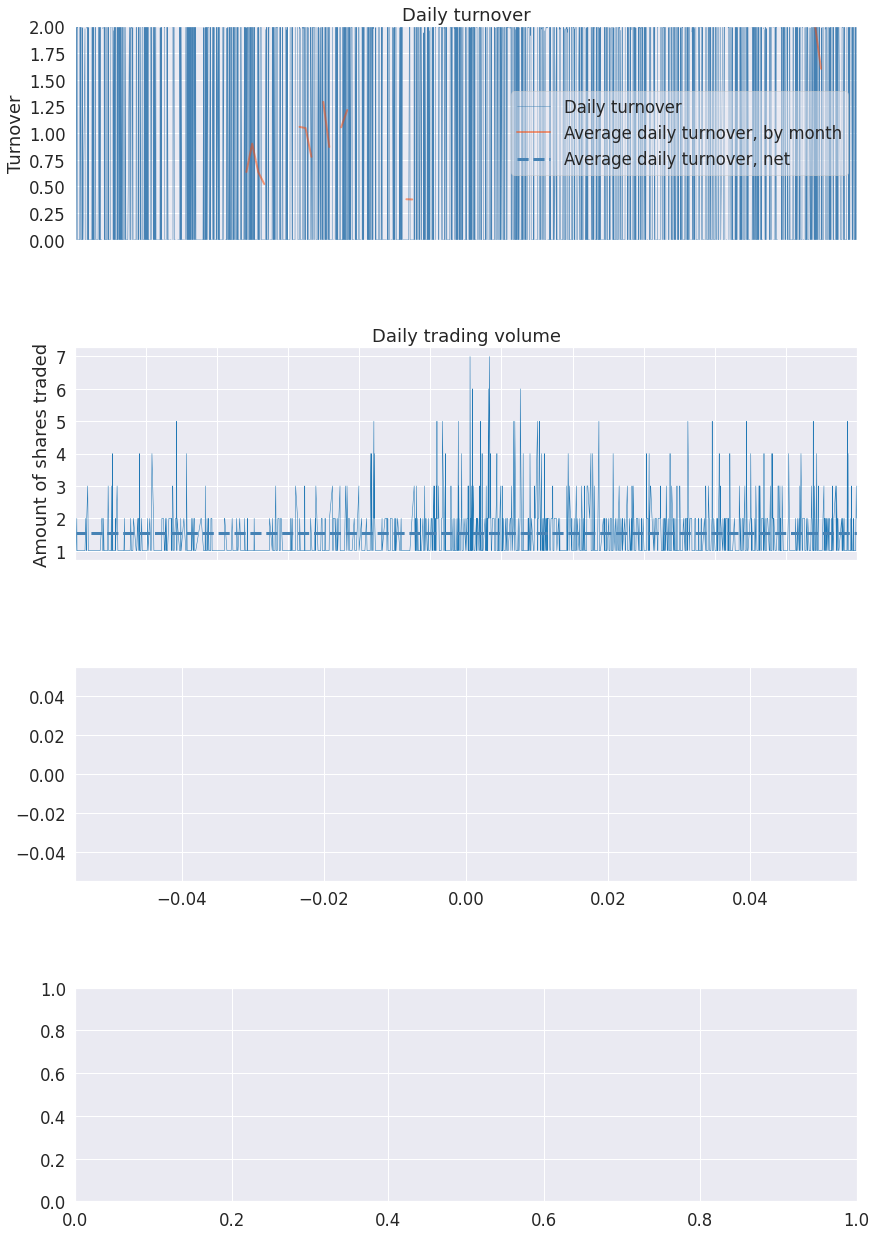

In [6]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)
import time,datetime
import os,sys
import pickle 
# import talib
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
from sklearn import linear_model

import backtesting as bt  
from backtesting.comminfo import ComminfoFuturesPercent,ComminfoFuturesFixed # 期货交易的手续费用，按照比例或者按照金额
import pyfolio as pf

# 编写一个新的macd的指标，使得和国内的常用macd指标接轨

        

### 编写相应的策略,每个策略逻辑需要单独编写，回测和实盘直接运行策略类就行

class MACDStrategy(bt.Strategy):
    # 策略的参数
    params = (  ("period_me1",10),                  
                ("period_me2",20),                      
                ("period_dif",9),             
                
            )
    # log相应的信息
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or bt.num2date(self.datas[0].datetime[0])
        print('{}, {}'.format(dt.isoformat(), txt))

    # 初始化策略的data_folder
    def __init__(self):
        # 基本上常用的部分属性变量
        self.bar_num = 0                 # next运行了多少个bar
        self.current_date = None        # 当前交易日
        # 计算macd指标
        self.ema_1 = bt.indicators.ExponentialMovingAverage(self.datas[0].close, period=self.p.period_me1)
        self.ema_2 = bt.indicators.ExponentialMovingAverage(self.datas[0].close, period=self.p.period_me2)
        self.dif = self.ema_1 - self.ema_2
        self.dea = bt.indicators.ExponentialMovingAverage(self.dif,period=self.p.period_dif)
        self.macd = (self.dif - self.dea)*2
        # 保存现在持仓的合约是哪一个
        self.holding_contract_name = None
 

    def prenext(self):
        # 由于期货data_folder有几千个，每个期货交易日期不同，并不会自然进入next
        # 需要在每个prenext中调用next函数进行运行
        self.next() 
        # pass 
        
    # 在next中添加相应的策略逻辑
    def next(self):
        # 每次运行一次，bar_num自然加1,并更新交易日
        self.current_date = bt.num2date(self.datas[0].datetime[0])
        self.bar_num+=1
        data = self.datas[0]
        # 开仓，先平后开
        # 平多
        if self.holding_contract_name is not None and self.getpositionbyname(self.holding_contract_name).size>0 and data.close[0]<self.ema_1[0]:
            data = self.getdatabyname(self.holding_contract_name)
            self.close(data)
            self.holding_contract_name = None
        # 平空
        if self.holding_contract_name is not None  and self.getpositionbyname(self.holding_contract_name).size<0 and data.close[0]>self.ema_1[0]:
            data = self.getdatabyname(self.holding_contract_name)
            self.close(data)
            self.holding_contract_name = None
            
        # 开多
        if self.holding_contract_name is None and self.ema_1[-1]<self.ema_2[-1] and self.ema_1[0]>self.ema_2[0] and self.macd[0]>0:
            dominant_contract = self.get_dominant_contract()
            next_data = self.getdatabyname(dominant_contract)
            self.buy(next_data,size=1)
            self.holding_contract_name = dominant_contract
        
        # 开空
        if self.holding_contract_name is None and self.ema_1[-1]>self.ema_2[-1] and self.ema_1[0]<self.ema_2[0] and self.macd[0]<0:
            dominant_contract = self.get_dominant_contract()
            next_data = self.getdatabyname(dominant_contract)
            self.sell(next_data,size=1)
            self.holding_contract_name = dominant_contract
            
        # 移仓换月
        if self.holding_contract_name is not None:
            dominant_contract = self.get_dominant_contract()
            # 如果出现了新的主力合约，那么就开始换月
            if dominant_contract!=self.holding_contract_name:
                # 下个主力合约
                next_data = self.getdatabyname(dominant_contract)
                # 当前合约持仓大小及data_folder
                size = self.getpositionbyname(self.holding_contract_name).size # 持仓大小
                data = self.getdatabyname(self.holding_contract_name)
                # 平掉旧的
                self.close(data)
                # 开新的
                if size>0:
                    self.buy(next_data,size=abs(size))
                if size<0:
                    self.sell(next_data,size=abs(size))
                self.holding_contract_name = dominant_contract
            
    def get_dominant_contract(self):
        
        # 以持仓量最大的合约作为主力合约,返回data_folder的名称
        # 可以根据需要，自己定义主力合约怎么计算
    
        # 获取当前在交易的品种
        target_datas=[]
        for data in self.datas[1:]: 
            try:
                data_date = bt.num2date(data.datetime[0])
                # self.log(f"{data._name},{data_date}")
                if self.current_date==data_date:
                    target_datas.append([data._name,data.openinterest[0]])
            except:
                self.log(f"{data._name}还未上市交易")
            
        target_datas = sorted(target_datas,key = lambda x:x[1])
        # print(target_datas)
        return target_datas[-1][0]
        
                
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status == order.Rejected:
            self.log(f"Rejected : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Margin:
            self.log(f"Margin : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Cancelled:
            self.log(f"Concelled : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Partial:
            self.log(f"Partial : order_ref:{order.ref}  data_name:{order.p.data._name}")
         
        if order.status == order.Completed:
            if order.isbuy():
                self.log(f" BUY : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")

            else:  # Sell
                self.log(f" SELL : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")
    
    def notify_trade(self, trade):
        # 一个trade结束的时候输出信息
        if trade.isclosed:
            self.log('closed symbol is : {} , total_profit : {} , net_profit : {}' .format(
                            trade.getdataname(),trade.pnl, trade.pnlcomm))
            
        if trade.isopen:
            self.log('open symbol is : {} , price : {} ' .format(
                            trade.getdataname(),trade.price))

            
    def stop(self):
        pass 
    
    
# 准备配置策略
cerebro = bt.Cerebro()
# 参数设置
data_kwargs = dict(
            fromdate = datetime.datetime(2010,1, 1),
            todate = datetime.datetime(2020,12,31),
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
            tmformat=('%H:%M:%S'), # 时间格式
            datetime=0,
            high=3,
            low=4,
            open=1,
            close=2,
            volume=5,
            openinterest=6)

data_root = "./future/15m/rb/"
# 加载具体的合约data_folder
file_list =os.listdir(data_root)
file_list.remove("RB99.csv")
# 确保传入的第一个data_folder是指数data_folder
for file in ["RB99.csv"]+file_list:
    name = file[:-4]
    df = pd.read_csv(data_root+file)
    # 只要data_folder里面的这几列
    df = df[['datetime','open','high','low','close','volume','openinterest']]
    # 修改列的名字
    df.index = pd.to_datetime(df['datetime'])
    df = df[['open','high','low','close','volume','openinterest']]
    df.columns = ['open','high','low','close','volume','openinterest']
    df = df[(df.index<=data_kwargs['todate'])&(df.index>=data_kwargs['fromdate'])]
    if len(df)==0:
        continue 
    feed = bt.feeds.PandasDirectData(dataname = df)
    cerebro.adddata(feed, name = name)
    # 设置合约的交易信息，佣金设置为2%%，保证金率为10%，杠杆按照真实的杠杆来
    comm=ComminfoFuturesPercent(commission=0.0002,margin=0.1, mult=10)
    cerebro.broker.addcommissioninfo(comm, name= name)
cerebro.broker.setcash(50000.0)
# 添加策略
cerebro.addstrategy(MACDStrategy)
cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
cerebro.addanalyzer(bt.analyzers.PyFolio)
# 运行回测
results = cerebro.run()

pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2019-01-01',
    )


肯特纳通道策略

策略逻辑

指标构建：计算最高价、最低价和收盘价的平均价，然后用平均价的avg_period作为中间线，计算avg_period个周期的atr，然后使用atr_multi*atr作为带宽，构建上下通道。

做多：无持仓时，当价格向上突破上轨，中间线是向上的，做多；

平多: 有多头仓位时，价格跌破中间线，平多；

做空：无持仓时，当价格向下突破下轨，中间线是向下的，做空；

平空: 当价格在10周期的ema上方的时候，平空。

交易手数：每次交易1手。

初始资金： 5万元

交易费用： 万分之二。

运行周期： 30分钟

运行方式：运行在30分钟指数合约上，在当时的主力合约上进行交易

策略点评

典型的趋势跟踪策略里面的突破策略，与布林带通道突破，四周突破等本质上都是类似的，都是企图抓住未来的大的趋势。这个 策略虽然简单，但是策略很有逻辑性，可以考虑进一步改进优化。

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


2013-12-13T14:30:00,  SELL : data_name:JD1405 price : 4097.0 , cost : 4097.0 , commission : 8.194
2013-12-13T14:30:00, open symbol is : JD1405 , price : 4097.0 
2014-01-03T10:00:00,  BUY : data_name:JD1405 price : 4027.0 , cost : 4097.0 , commission : 8.054
2014-01-03T10:00:00, closed symbol is : JD1405 , total_profit : 700.0 , net_profit : 683.752
2014-01-07T09:30:00,  SELL : data_name:JD1405 price : 3832.0 , cost : 3832.0 , commission : 7.664000000000001
2014-01-07T09:30:00, open symbol is : JD1405 , price : 3832.0 
2014-01-28T10:00:00,  BUY : data_name:JD1405 price : 3734.0 , cost : 3832.0 , commission : 7.468
2014-01-28T10:00:00, closed symbol is : JD1405 , total_profit : 980.0 , net_profit : 964.868
2014-01-28T11:00:00,  BUY : data_name:JD1405 price : 3749.0 , cost : 3749.0 , commission : 7.498
2014-01-28T11:00:00, open symbol is : JD1405 , price : 3749.0 
2014-02-26T09:30:00,  SELL : data_name:JD1405 price : 3680.0 , cost : 3749.0 , commission : 7.36
2014-02-26T09:30:00, closed s

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is depre

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:1147: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/timeseries.py:1147: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  cone_bounds = pd.DataFrame(columns=pd.Float64Index([]))
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:red'` for same effect.
  warnings.warn(msg, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-pac

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:1546: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(turnover, ax=ax, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/tears.py:779: UserWarning: Unable to generate turnover plot.
  warnings.warn('Unable to generate turnover plot.', UserWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pyfolio/plotting.py:1626: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either sp

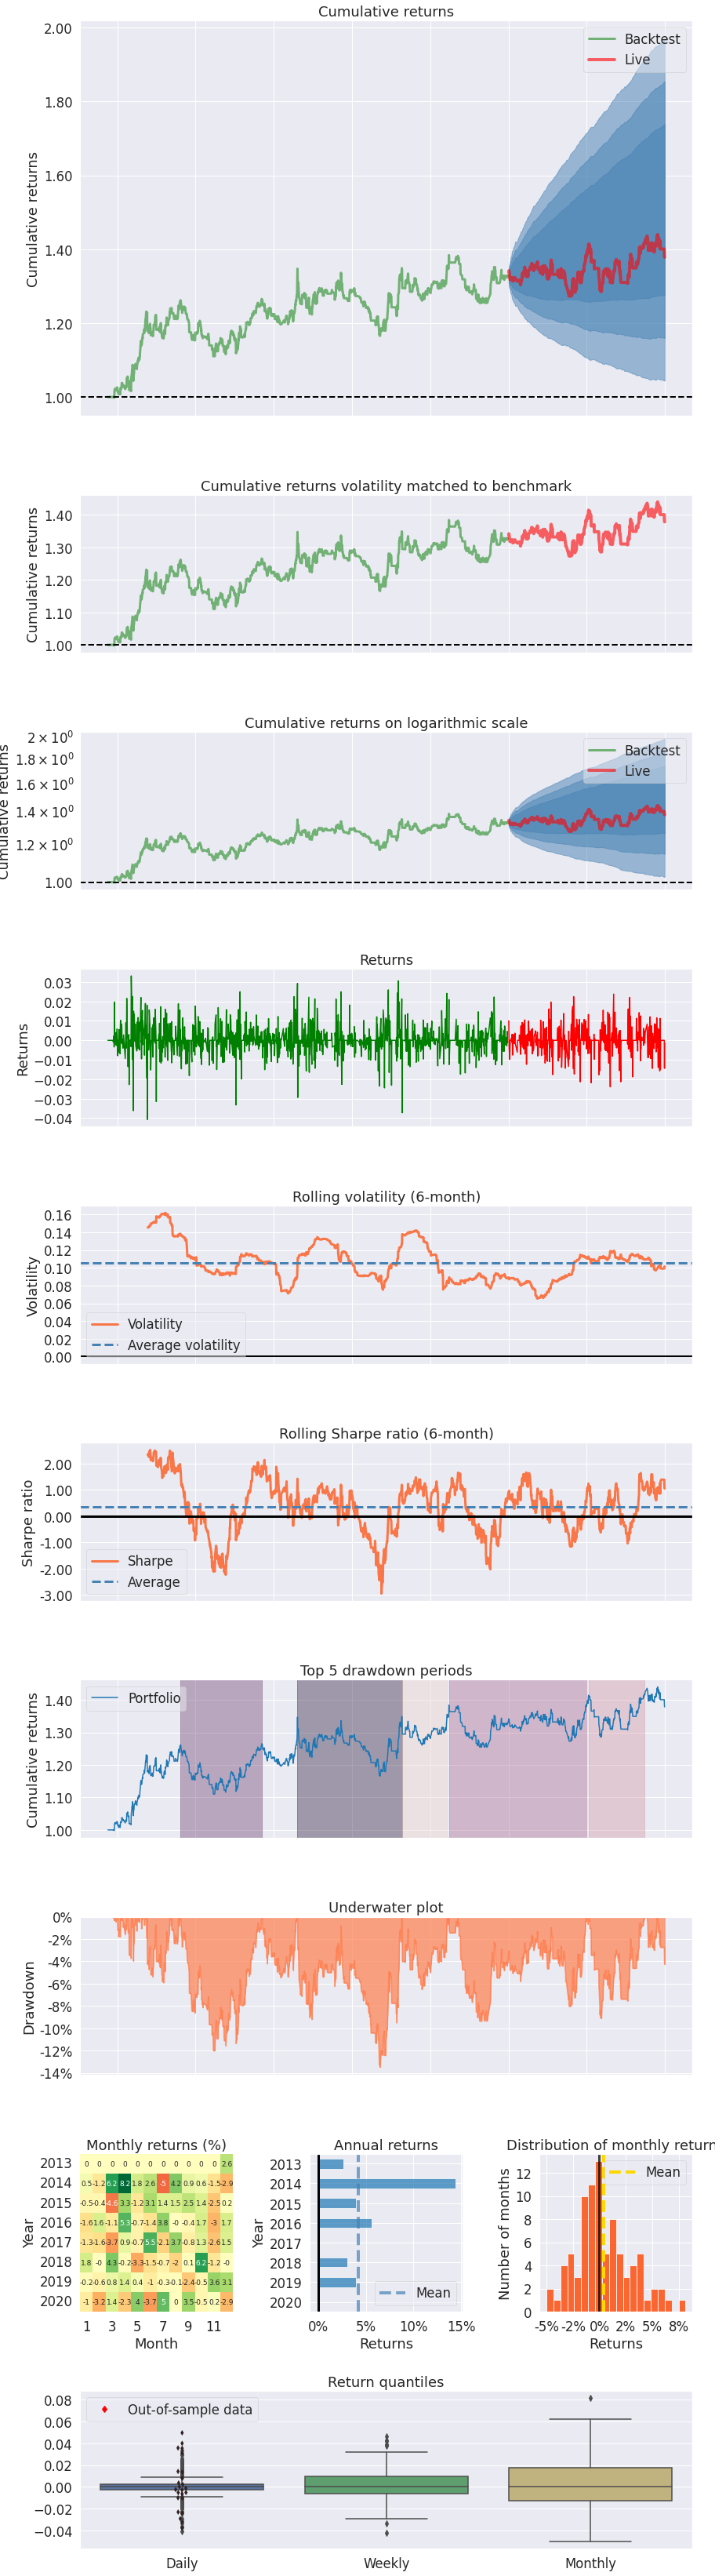

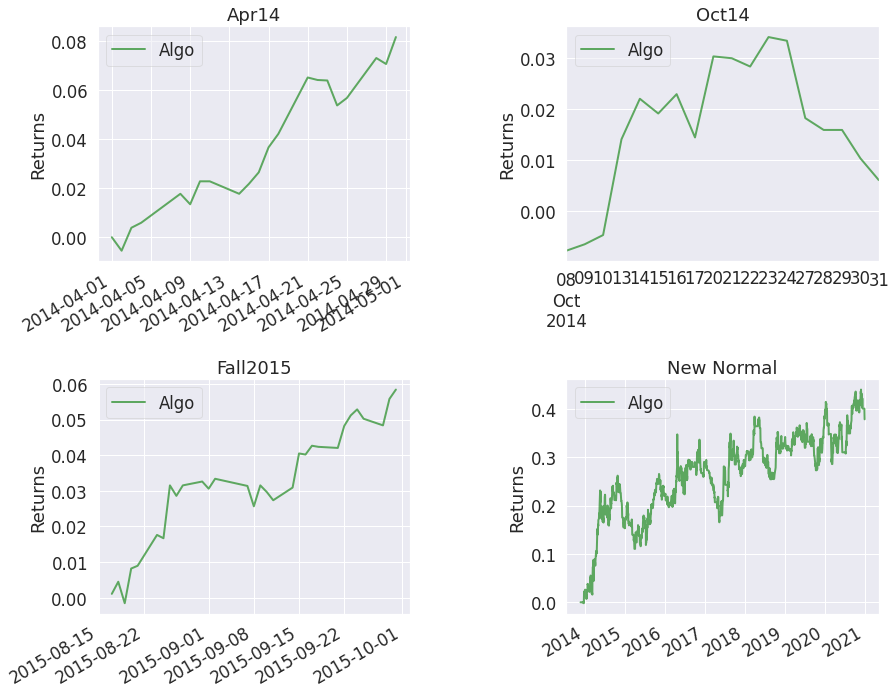

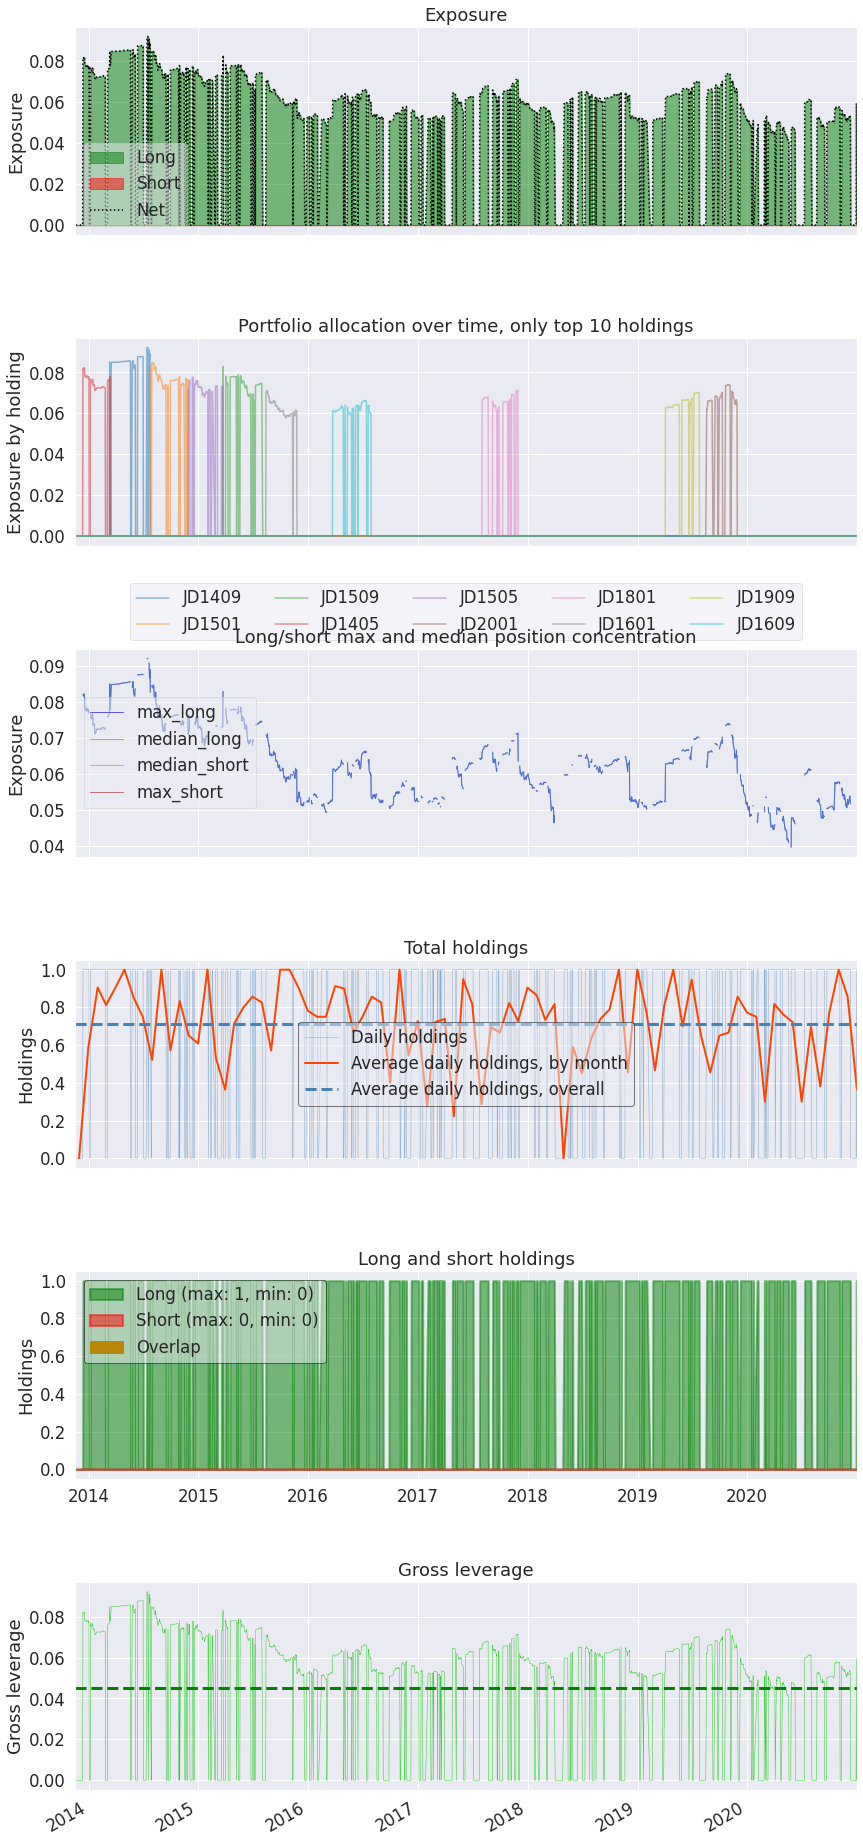

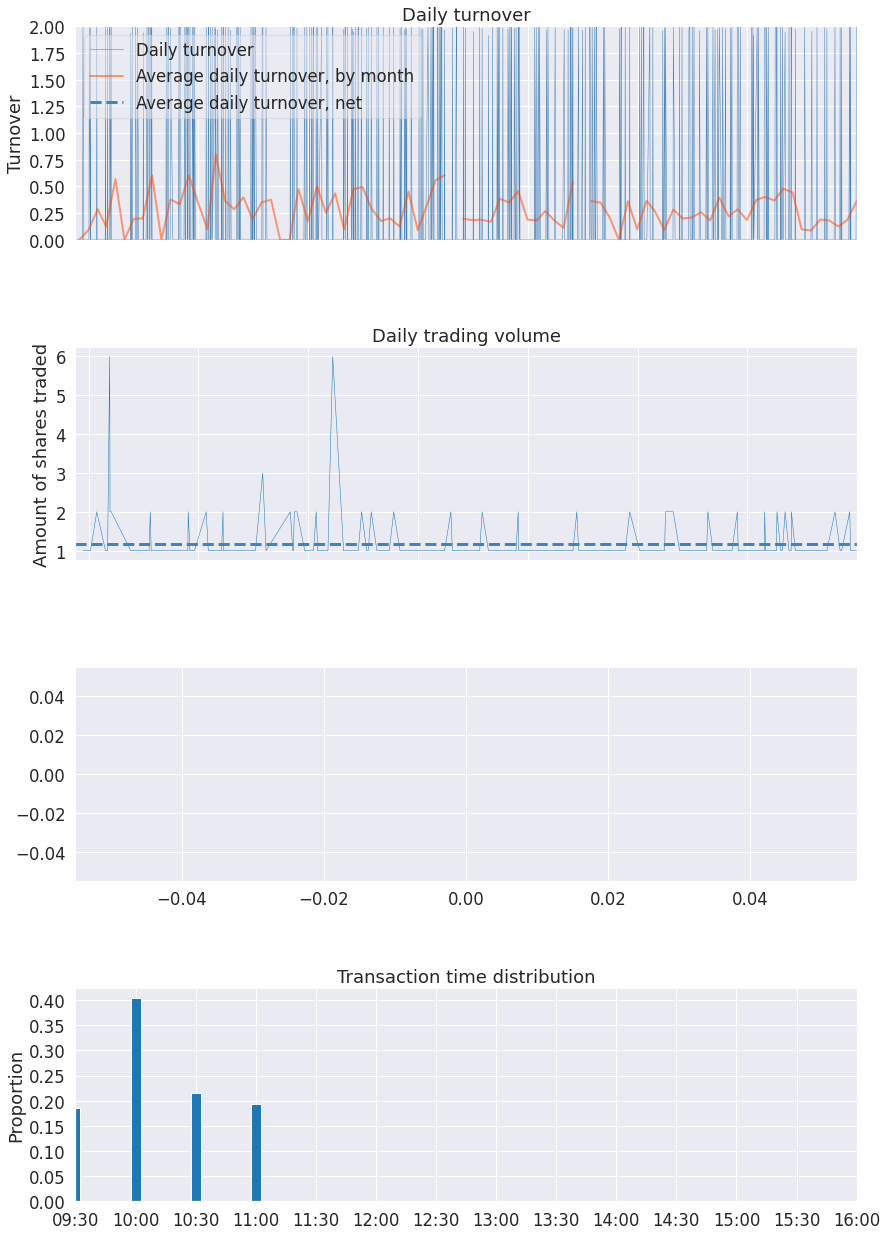

In [1]:
import time,datetime
import os,sys
import pickle 
import numpy as np
import pandas as pd
import random
import statsmodels.api as sm
from sklearn import linear_model

import backtesting   as bt  
from backtesting.comminfo import ComminfoFuturesPercent,ComminfoFuturesFixed # 期货交易的手续费用，按照比例或者按照金额

import pyfolio as pf

# 编写一个新的macd的指标，使得和国内的常用macd指标接轨

        

### 编写相应的策略,每个策略逻辑需要单独编写，回测和实盘直接运行策略类就行

class KeltnerStrategy(bt.Strategy):
    # 策略的参数
    params = (  ("avg_period",110),                  
                ("atr_multi",3),                           
            )
    # log相应的信息
    def log(self, txt, dt=None):
        ''' Logging function fot this strategy'''
        dt = dt or bt.num2date(self.datas[0].datetime[0])
        print('{}, {}'.format(dt.isoformat(), txt))

    # 初始化策略的data_folder
    def __init__(self):
        # 基本上常用的部分属性变量
        self.bar_num = 0                 # next运行了多少个bar
        self.current_date = None        # 当前交易日
        # 计算macd指标
        self.middle_price = (self.datas[0].high+ self.datas[0].low+ self.datas[0].close)/3
        self.middle_line = bt.indicators.SMA(self.middle_price, period = self.p.avg_period)
        self.atr = bt.indicators.AverageTrueRange(self.datas[0],period = self.p.avg_period )
        self.upper_line = self.middle_line+self.atr*self.p.atr_multi
        self.lower_line = self.middle_line-self.atr*self.p.atr_multi
        # 保存现在持仓的合约是哪一个
        self.holding_contract_name = None
 

    def prenext(self):
        # 由于期货data_folder有几千个，每个期货交易日期不同，并不会自然进入next
        # 需要在每个prenext中调用next函数进行运行
        self.next() 
        # pass 
        
    # 在next中添加相应的策略逻辑
    def next(self):
        # 每次运行一次，bar_num自然加1,并更新交易日
        self.current_date = bt.num2date(self.datas[0].datetime[0])
        self.bar_num+=1
        data = self.datas[0]
        # 开仓，先平后开
        # 平多
        if self.holding_contract_name is not None and self.getpositionbyname(self.holding_contract_name).size>0 and data.close[0]<self.middle_line[0]:
            data = self.getdatabyname(self.holding_contract_name)
            self.close(data)
            self.holding_contract_name = None
        # 平空
        if self.holding_contract_name is not None  and self.getpositionbyname(self.holding_contract_name).size<0 and data.close[0]>self.middle_line[0]:
            data = self.getdatabyname(self.holding_contract_name)
            self.close(data)
            self.holding_contract_name = None
            
        # 开多
        if self.holding_contract_name is None and data.close[-1]<self.upper_line[-1] and data.close[0]>self.upper_line[0] and self.middle_line[0]>self.middle_line[-1]:
            dominant_contract = self.get_dominant_contract()
            next_data = self.getdatabyname(dominant_contract)
            self.buy(next_data,size=1)
            self.holding_contract_name = dominant_contract
        
        # 开空
        if self.holding_contract_name is None and data.close[-1]>self.lower_line[-1] and data.close[0]<self.lower_line[0] and self.middle_line[0]<self.middle_line[-1]:
            dominant_contract = self.get_dominant_contract()
            next_data = self.getdatabyname(dominant_contract)
            self.sell(next_data,size=1)
            self.holding_contract_name = dominant_contract
            
        # 移仓换月
        if self.holding_contract_name is not None:
            dominant_contract = self.get_dominant_contract()
            # 如果出现了新的主力合约，那么就开始换月
            if dominant_contract!=self.holding_contract_name:
                # 下个主力合约
                next_data = self.getdatabyname(dominant_contract)
                # 当前合约持仓大小及data_folder
                size = self.getpositionbyname(self.holding_contract_name).size # 持仓大小
                data = self.getdatabyname(self.holding_contract_name)
                # 平掉旧的
                self.close(data)
                # 开新的
                if size>0:
                    self.buy(next_data,size=abs(size))
                if size<0:
                    self.sell(next_data,size=abs(size))
                self.holding_contract_name = dominant_contract
            
    def get_dominant_contract(self):
        
        # 以持仓量最大的合约作为主力合约,返回data_folder的名称
        # 可以根据需要，自己定义主力合约怎么计算
    
        # 获取当前在交易的品种
        target_datas=[]
        for data in self.datas[1:]: 
            try:
                data_date = bt.num2date(data.datetime[0])
                # self.log(f"{data._name},{data_date}")
                if self.current_date==data_date:
                    target_datas.append([data._name,data.openinterest[0]])
            except:
                self.log(f"{data._name}还未上市交易")
            
        target_datas = sorted(target_datas,key = lambda x:x[1])
        # print(target_datas)
        return target_datas[-1][0]
        
                
    def notify_order(self, order):
        
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status == order.Rejected:
            self.log(f"Rejected : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Margin:
            self.log(f"Margin : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Cancelled:
            self.log(f"Concelled : order_ref:{order.ref}  data_name:{order.p.data._name}")
            
        if order.status == order.Partial:
            self.log(f"Partial : order_ref:{order.ref}  data_name:{order.p.data._name}")
         
        if order.status == order.Completed:
            if order.isbuy():
                self.log(f" BUY : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")

            else:  # Sell
                self.log(f" SELL : data_name:{order.p.data._name} price : {order.executed.price} , cost : {order.executed.value} , commission : {order.executed.comm}")
    
    def notify_trade(self, trade):
        # 一个trade结束的时候输出信息
        if trade.isclosed:
            self.log('closed symbol is : {} , total_profit : {} , net_profit : {}' .format(
                            trade.getdataname(),trade.pnl, trade.pnlcomm))
            # self.trade_list.append([self.datas[0].datetime.date(0),trade.getdataname(),trade.pnl,trade.pnlcomm])
            
        if trade.isopen:
            self.log('open symbol is : {} , price : {} ' .format(
                            trade.getdataname(),trade.price))

            
    def stop(self):
        # 策略停止的时候输出信息
        pass 
    
    
# 准备配置策略
cerebro = bt.Cerebro()
# 参数设置
data_kwargs = dict(
            fromdate = datetime.datetime(2013,11, 18),
            todate = datetime.datetime(2020,12,31),
            timeframe = bt.TimeFrame.Minutes,
            compression = 1,
            dtformat=('%Y-%m-%d %H:%M:%S'), # 日期和时间格式
            tmformat=('%H:%M:%S'), # 时间格式
            datetime=0,
            high=3,
            low=4,
            open=1,
            close=2,
            volume=5,
            openinterest=6)

data_root = "./future/15m/jd/"
# 加载具体的合约data_folder
file_list =os.listdir(data_root)
file_list.remove("JD99.csv")
# 确保传入的第一个data_folder是指数data_folder
for file in ["JD99.csv"]+file_list:
    name = file[:-4]
    df = pd.read_csv(data_root+file)
    # 只要data_folder里面的这几列
    df = df[['datetime','open','high','low','close','volume','openinterest']]
    # 修改列的名字
    df.index = pd.to_datetime(df['datetime'])
    # 如果对data_folder的时间顺序比较确定是从小到大的，可以不用排序，否则最好做下排序
    df = df[['open','high','low','close','volume','openinterest']]
    df = df[(df.index<=data_kwargs['todate'])&(df.index>=data_kwargs['fromdate'])]
    if len(df)==0:
        continue 
    feed = bt.feeds.PandasDirectData(dataname = df)
    cerebro.adddata(feed, name = name)
    # 设置合约的交易信息，佣金设置为2%%，保证金率为10%(交易所加期货公司部分，每个人可能不一样)，杠杆按照真实的杠杆来
    comm=ComminfoFuturesPercent(commission=0.0002,margin=0.1, mult=10)
    cerebro.broker.addcommissioninfo(comm, name= name)
cerebro.broker.setcash(50000.0)
# 添加策略
cerebro.addstrategy(KeltnerStrategy)
cerebro.addanalyzer(bt.analyzers.TotalValue, _name='_TotalValue')
cerebro.addanalyzer(bt.analyzers.PyFolio)

# 运行回测
results = cerebro.run()

pyfoliozer = results[0].analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
pf.create_full_tear_sheet(
    returns,
    positions=positions,
    transactions=transactions,
    # gross_lev=gross_lev,
    live_start_date='2019-01-01',
    )
